C:\Users\saika\AppData\Local\Temp\ipykernel_146204\109533782.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['ds'] = pd.to_datetime(data['Date'])
21:51:51 - cmdstanpy - INFO - Chain [1] start processing
21:51:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:51:51 - cmdstanpy - INFO - Chain [1] start processing
21:51:52 - cmdstanpy - INFO - Chain [1] done processing
21:51:52 - cmdstanpy - INFO - Chain [1] start processing
21:51:52 - cmdstanpy - INFO - Chain [1] done processing


          rmse         mae      mape
0   419.209200  362.834209  0.132248
1   358.276446  328.805558  0.148545
2   329.336015  299.243793  0.124455
3   420.611663  383.338015  0.158350
4   403.895810  359.980808  0.125376
5   813.908896  631.770822  0.173456
6   868.076527  708.238946  0.210073
7   881.286486  758.088505  0.237142
8   496.457530  428.077288  0.174865
9   289.978950  243.025355  0.088093
10  434.863119  297.890318  0.081610
11  518.405807  383.051458  0.109858
12  708.225152  599.260890  0.215251
13  840.272354  745.001808  0.283717
14  818.545742  738.123258  0.276594
15  763.958220  694.932035  0.311656
16  473.816017  382.401448  0.209169
17  562.817943  438.860931  0.206647
18  426.251804  306.228356  0.085745
19  852.782071  682.451525  0.217361
20  783.247896  586.707233  0.223984
21  766.760524  513.043107  0.198056
22  291.500760  208.652336  0.115795
23  268.602090  193.440863  0.088674
24  503.606560  394.475735  0.133640
25  522.757984  442.400774  0.123489
2

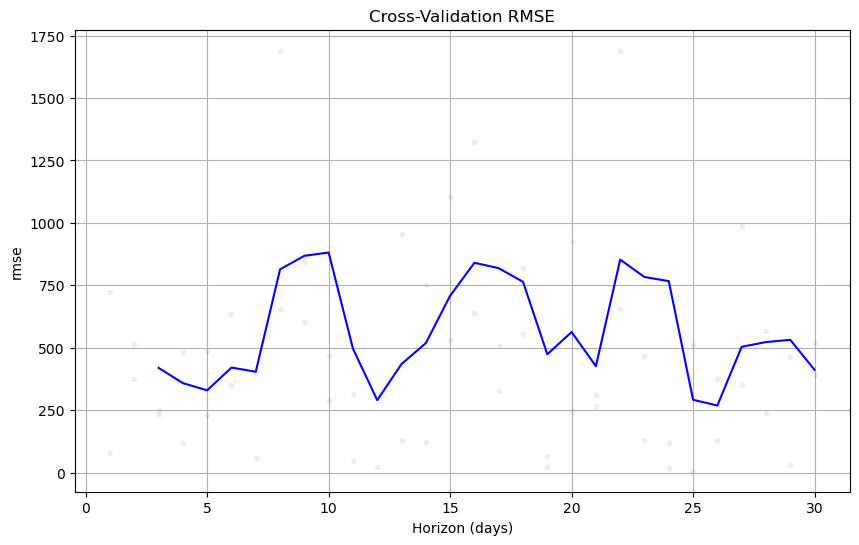

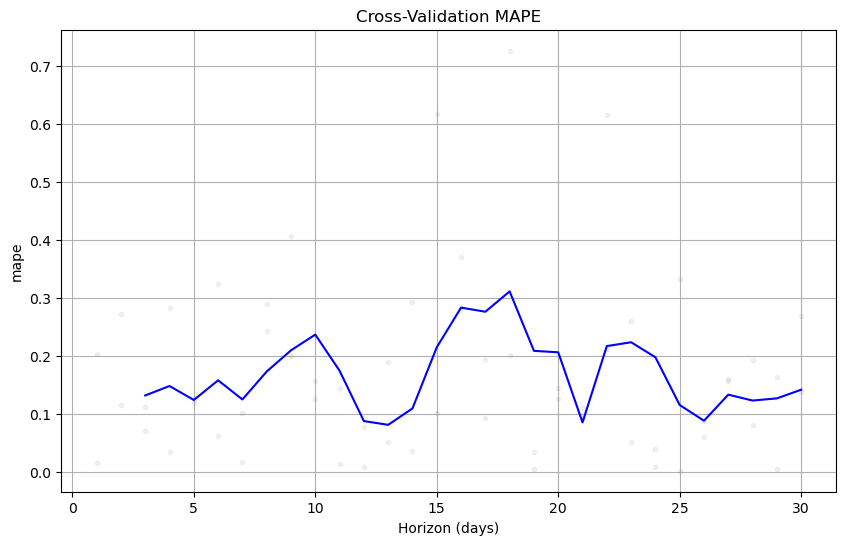

R-squared: 0.79


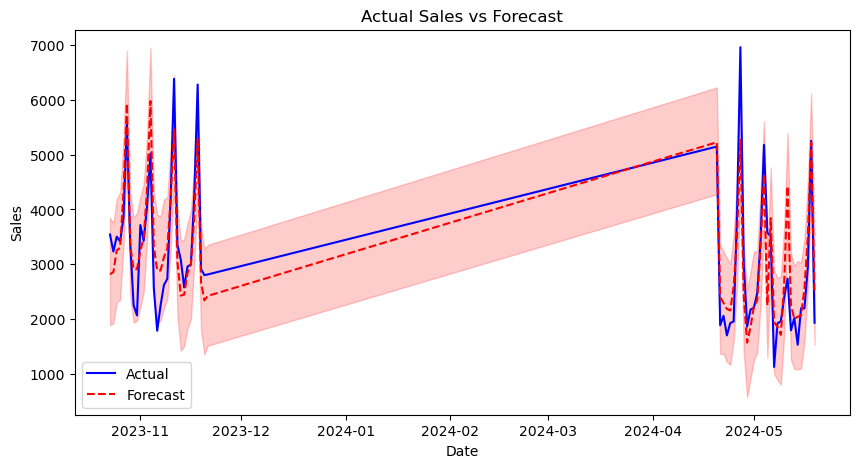

In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, message="Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified.")
warnings.filterwarnings('ignore', category=FutureWarning, message=".*fillna.*")
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
data = pd.read_csv('Fixed_Combined_Sales_Data.csv')
data['ds'] = pd.to_datetime(data['Date'])
data['y'] = data['TotalNetSales']

# Add weather data and encode weather conditions
data['temperature'] = data['feelslike']
weather_dummies = pd.get_dummies(data['icon'])
data = pd.concat([data, weather_dummies], axis=1)

# Define holidays and special events (Pre-Christmas two weeks)
holidays = data[data['Is_Holiday'] == 1][['ds', 'Holiday_Name']]
holidays['holiday'] = holidays['Holiday_Name']
holidays['lower_window'] = 0
holidays['upper_window'] = 1

# Add Pre-Christmas two weeks before 25th December each year
data['year'] = data['ds'].dt.year
pre_christmas_start = pd.to_datetime(data['year'].astype(str) + '-12-11')
pre_christmas_end = pd.to_datetime(data['year'].astype(str) + '-12-24')

pre_christmas = pd.DataFrame({
    'holiday': 'Pre-Christmas',
    'ds': [pd.date_range(start, end) for start, end in zip(pre_christmas_start, pre_christmas_end)],
    'lower_window': 0,
    'upper_window': 1,
}).explode('ds').drop_duplicates()

# Combine regular and special holidays
holidays = pd.concat([holidays, pre_christmas], ignore_index=True)

model = Prophet(holidays=holidays)
model.add_regressor('temperature')
for condition in weather_dummies.columns:
    model.add_regressor(condition)

# Fit the model on the historical data
model.fit(data[['ds', 'y', 'temperature'] + list(weather_dummies.columns)])

# Create future DataFrame for forecasting
future = model.make_future_dataframe(periods=30, include_history=True)

# Assume future weather conditions or use last known data
future = future.merge(data[['ds', 'temperature'] + list(weather_dummies.columns)], on='ds', how='left', sort=False)

# Handle missing data if any
future.fillna(method='ffill', inplace=True)
future.fillna(method='bfill', inplace=True)

# Create future DataFrame for forecasting
future = model.make_future_dataframe(periods=30, include_history=True)

# Assume future weather conditions or use last known data
future = future.merge(data[['ds', 'temperature'] + list(weather_dummies.columns)], on='ds', how='left', sort=False)

# Handle missing data if any
future.fillna(method='ffill', inplace=True)
future.fillna(method='bfill', inplace=True)

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p[['rmse', 'mae', 'mape']])

# Calculate and print the average RMSE
avg_rmse = df_p['rmse'].mean()
print("Average RMSE:", avg_rmse)

# Calculate and print the average MAE
avg_mae = df_p['mae'].mean()
print("Average MAE:", avg_mae)

# Calculate and print the average MAPE
avg_mape = df_p['mape'].mean()
print("Average MAPE:", avg_mape)

# Plot RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title('Cross-Validation RMSE')
plt.show()

# Plot MAPE
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('Cross-Validation MAPE')
plt.show()


# Calculate SSR (sum of squares of residuals)
ssr = np.sum((df_cv['y'] - df_cv['yhat'])**2)

# Calculate SST (total sum of squares)
sst = np.sum((df_cv['y'] - np.mean(df_cv['y']))**2)

# Calculate R-squared
r_squared = 1 - (ssr / sst)
print(f"R-squared: {r_squared:.2f}")


plt.figure(figsize=(10, 5))
plt.plot(df_cv['ds'], df_cv['y'], 'b-', label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], 'r--', label='Forecast')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='red', alpha=0.2)
plt.title('Actual Sales vs Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [2]:
!pip install --upgrade prophet
!pip install --upgrade numpy

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.9 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 817.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
    --------------------------------------- 0.2/16.6 MB 4.8 MB/s eta 0:00:04
   - -------------------------------------- 0.7/16.6 MB 7.7 MB/s eta 0:00:03
   --- ------------------------------------ 1.3/16.6 MB 11.7 MB/s eta 0:00:02
   ------ --------------------------------- 2.6/16.6 MB 14.9 MB/s eta 0:00:01
   -------- ------------------------------- 3.7/16.6 MB 18.2 MB/s eta 0:00:01
   ---------- ----------------------------- 4.4/16.6 MB 18.6 MB/s eta 0:00:01
   --------------- ------------------------ 6.6/16.6 MB 21.1 MB/s eta 0:00:01
   ------------------- -------------------- 8.2/16.6 MB 22.8 MB/s eta 0:00:01
   --------------------- ------------------ 9.1/16.6 MB 23.3 MB/s eta 0:00:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.1 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.1 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.0.1 which is incompatible.
numba 0.59.0 requires numpy<1.27,>=1.22, but you have numpy 2.0.1 which is incompatible.
pandas 2.1.4 requires numpy<2,>=1.23.2; python_version == "3.11", but you have numpy 2.0.1 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.0.1 which is incompatible.
scipy 1.11.4 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.0.1 which is incompatible.
streamlit 1.30.0 requires numpy<2,>=1.19.3, but you have numpy 2.0.1 which is incompatible.


In [3]:
pip install numpy==1.23.2

  Using cached numpy-1.23.2-cp311-cp311-win_amd64.whl.metadata (2.2 kB)
Using cached numpy-1.23.2-cp311-cp311-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyfume 0.3.4 requires numpy==1.24.4, but you have numpy 1.23.2 which is incompatible.


In [2]:
!pip install FuzzyTM>=0.4.0

In [4]:
!pip install numpy==1.24.4

  Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.2
    Uninstalling numpy-1.23.2:
      Successfully uninstalled numpy-1.23.2


In [9]:
!pip install --upgrade pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB 1.4 MB/s eta 0:00:09
   ---------------------------------------- 0.1/11.6 MB 2.1 MB/s eta 0:00:06
   -- ------------------------------------- 0.6/11.6 MB 5.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.4/11.6 MB 8.9 MB/s eta 0:00:02
   --------- ------------------------------ 2.7/11.6 MB 13.5 MB/s eta 0:00:01
   --------------- ------------------------ 4.6/11.6 MB 18.4 MB/s eta 0:00:01
   ------------------ --------------------- 5.5/11.6 MB 18.5 MB/s eta 0:00:01
   ----------------------- ---------------- 6.9/11.6 MB 20.0 MB/s eta 0:00:01
   ----------------------------- ---------- 8.5/11.6 MB 21.8 MB/s eta 0:00:01
   --------------------------------- ------ 9.8/11.6 MB 22.4 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 31.2 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 29.8 MB/s eta 0:00

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyfume 0.3.4 requires pandas==1.5.3, but you have pandas 2.2.2 which is incompatible.


In [6]:
pip list

Package                           Version
--------------------------------- ------------
aext_assistant                    0.4.0
aext_assistant_server             0.4.0
aext_core                         0.4.0
aext_core_server                  0.4.0
aext_shared                       0.4.0
aiobotocore                       2.7.0
aiofiles                          22.1.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
aiosqlite                         0.18.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.2
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi               

22:05:02 - cmdstanpy - INFO - Chain [1] start processing
22:05:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

22:05:02 - cmdstanpy - INFO - Chain [1] start processing
22:05:02 - cmdstanpy - INFO - Chain [1] done processing
22:05:03 - cmdstanpy - INFO - Chain [1] start processing
22:05:03 - cmdstanpy - INFO - Chain [1] done processing


          rmse         mae      mape
0   419.209200  362.834209  0.132248
1   358.276446  328.805558  0.148545
2   329.336015  299.243793  0.124455
3   420.611663  383.338015  0.158350
4   403.895810  359.980808  0.125376
5   813.908896  631.770822  0.173456
6   868.076527  708.238946  0.210073
7   881.286486  758.088505  0.237142
8   496.457530  428.077288  0.174865
9   289.978950  243.025355  0.088093
10  434.863119  297.890318  0.081610
11  518.405807  383.051458  0.109858
12  708.225152  599.260890  0.215251
13  840.272354  745.001808  0.283717
14  818.545742  738.123258  0.276594
15  763.958220  694.932035  0.311656
16  473.816017  382.401448  0.209169
17  562.817943  438.860931  0.206647
18  426.251804  306.228356  0.085745
19  852.782071  682.451525  0.217361
20  783.247896  586.707233  0.223984
21  766.760524  513.043107  0.198056
22  291.500760  208.652336  0.115795
23  268.602090  193.440863  0.088674
24  503.606560  394.475735  0.133640
25  522.757984  442.400774  0.123489
2

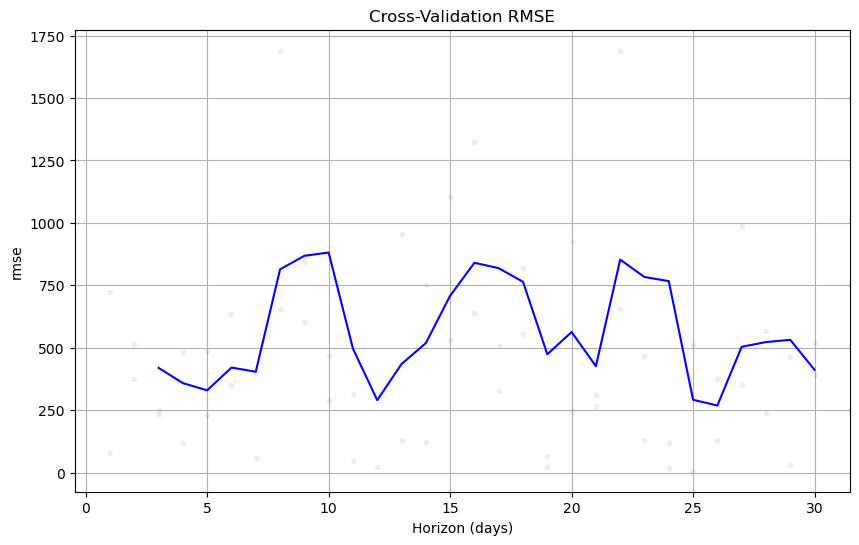

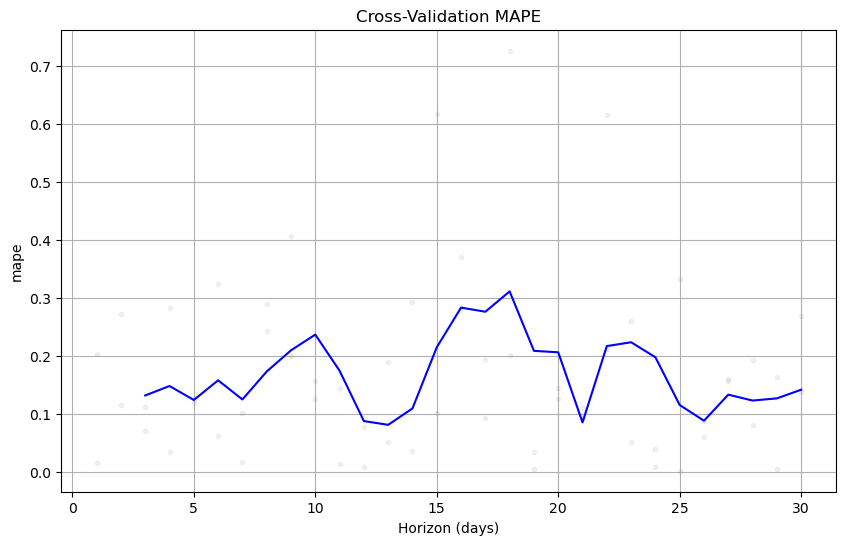

C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

R-squared: 0.79


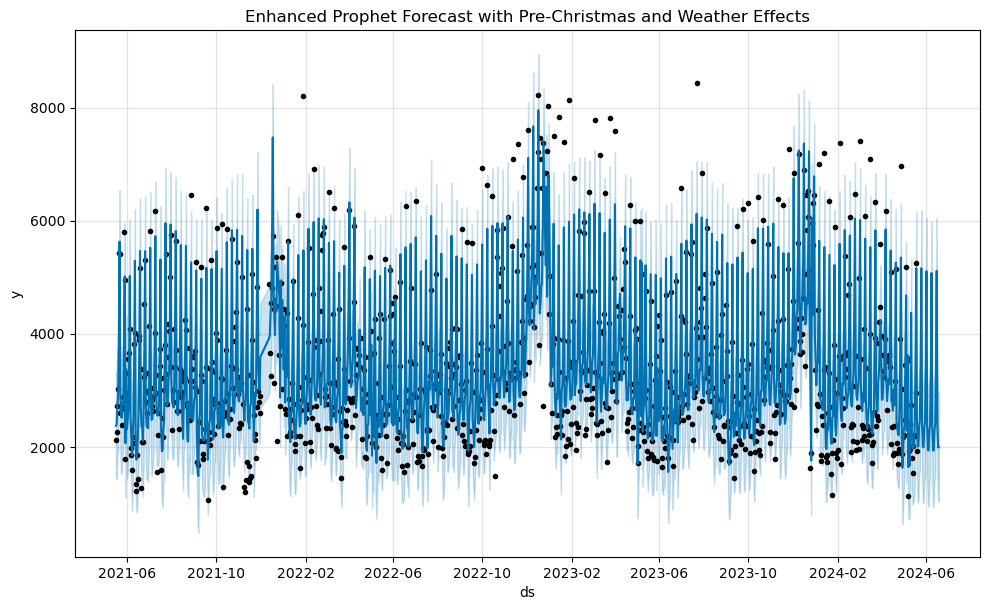

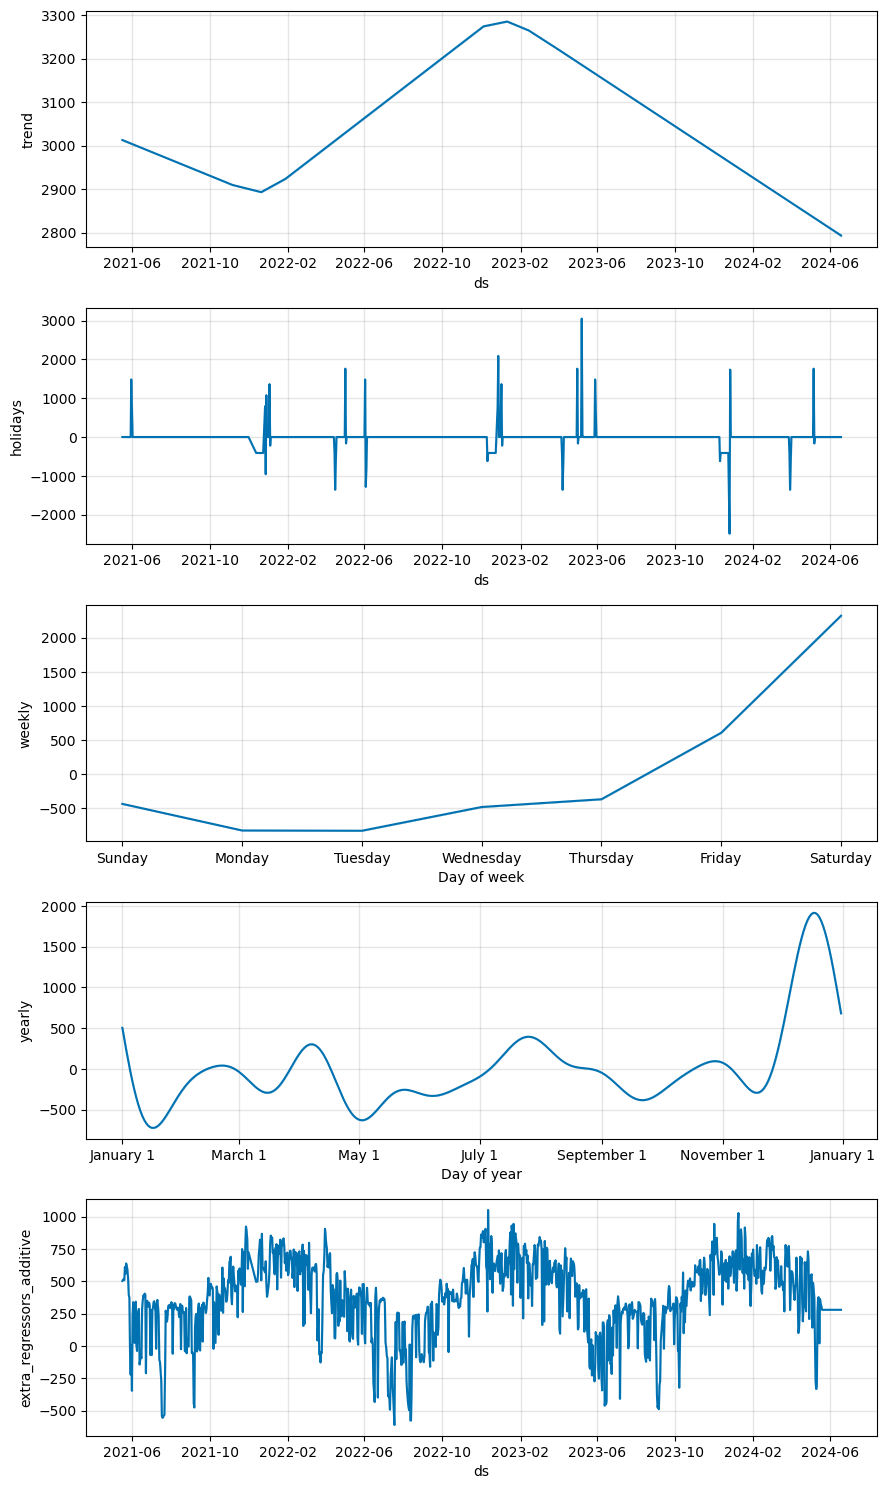

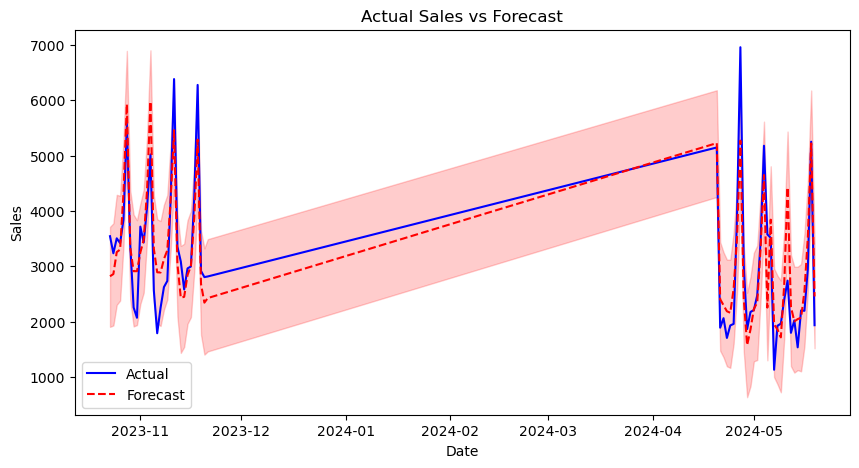

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, message="Parsing dates in .*")
warnings.filterwarnings('ignore', category=FutureWarning, message=".*fillna.*")
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
data = pd.read_csv('Fixed_Combined_Sales_Data.csv')
data['ds'] = pd.to_datetime(data['Date'], dayfirst=True)  # Ensure correct date format
data['y'] = data['TotalNetSales']

# Add weather data and encode weather conditions
data['temperature'] = data['feelslike']
weather_dummies = pd.get_dummies(data['icon'])
data = pd.concat([data, weather_dummies], axis=1)

# Define holidays and special events (Pre-Christmas two weeks)
holidays = data[data['Is_Holiday'] == 1][['ds', 'Holiday_Name']]
holidays['holiday'] = holidays['Holiday_Name']
holidays['lower_window'] = 0
holidays['upper_window'] = 1

# Add Pre-Christmas two weeks before 25th December each year
data['year'] = data['ds'].dt.year
pre_christmas_start = pd.to_datetime(data['year'].astype(str) + '-12-11')
pre_christmas_end = pd.to_datetime(data['year'].astype(str) + '-12-24')

pre_christmas = pd.DataFrame({
    'holiday': 'Pre-Christmas',
    'ds': [pd.date_range(start, end) for start, end in zip(pre_christmas_start, pre_christmas_end)],
    'lower_window': 0,
    'upper_window': 1,
}).explode('ds').drop_duplicates()

# Combine regular and special holidays
holidays = pd.concat([holidays, pre_christmas], ignore_index=True)

model = Prophet(holidays=holidays)
model.add_regressor('temperature')
for condition in weather_dummies.columns:
    model.add_regressor(condition)

# Fit the model on the historical data
model.fit(data[['ds', 'y', 'temperature'] + list(weather_dummies.columns)])

# Create future DataFrame for forecasting
future = model.make_future_dataframe(periods=30, include_history=True)

# Assume future weather conditions or use last known data
future = future.merge(data[['ds', 'temperature'] + list(weather_dummies.columns)], on='ds', how='left', sort=False)

# Handle missing data if any
future.ffill(inplace=True)
future.bfill(inplace=True)

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p[['rmse', 'mae', 'mape']])

# Calculate and print the average RMSE
avg_rmse = df_p['rmse'].mean()
print("Average RMSE:", avg_rmse)

# Calculate and print the average MAE
avg_mae = df_p['mae'].mean()
print("Average MAE:", avg_mae)

# Calculate and print the average MAPE
avg_mape = df_p['mape'].mean()
print("Average MAPE:", avg_mape)

# Plot RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title('Cross-Validation RMSE')
plt.show()

# Plot MAPE
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('Cross-Validation MAPE')
plt.show()

# Predict the future
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Enhanced Prophet Forecast with Pre-Christmas and Weather Effects')

# Plot the forecast components
components_fig = model.plot_components(forecast)

# Calculate SSR (sum of squares of residuals)
ssr = np.sum((df_cv['y'] - df_cv['yhat'])**2)

# Calculate SST (total sum of squares)
sst = np.sum((df_cv['y'] - np.mean(df_cv['y']))**2)

# Calculate R-squared
r_squared = 1 - (ssr / sst)
print(f"R-squared: {r_squared:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(df_cv['ds'], df_cv['y'], 'b-', label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], 'r--', label='Forecast')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='red', alpha=0.2)
plt.title('Actual Sales vs Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [1]:
!pip install joblib

In [8]:
pip list

Package                           Version
--------------------------------- ------------
aext_assistant                    0.4.0
aext_assistant_server             0.4.0
aext_core                         0.4.0
aext_core_server                  0.4.0
aext_shared                       0.4.0
aiobotocore                       2.7.0
aiofiles                          22.1.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
aiosqlite                         0.18.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.2
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi               

17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing


Index(['clear-day', 'cloudy', 'partly-cloudy-day', 'rain', 'snow'], dtype='object')


  0%|          | 0/2 [00:00<?, ?it/s]

17:27:35 - cmdstanpy - INFO - Chain [1] start processing
17:27:35 - cmdstanpy - INFO - Chain [1] done processing
17:27:35 - cmdstanpy - INFO - Chain [1] start processing
17:27:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


          rmse         mae      mape
0   419.209200  362.834209  0.132248
1   358.276446  328.805558  0.148545
2   329.336015  299.243793  0.124455
3   420.611663  383.338015  0.158350
4   403.895810  359.980808  0.125376
5   813.908896  631.770822  0.173456
6   868.076527  708.238946  0.210073
7   881.286486  758.088505  0.237142
8   496.457530  428.077288  0.174865
9   289.978950  243.025355  0.088093
10  434.863119  297.890318  0.081610
11  518.405807  383.051458  0.109858
12  708.225152  599.260890  0.215251
13  840.272354  745.001808  0.283717
14  818.545742  738.123258  0.276594
15  763.958220  694.932035  0.311656
16  473.816017  382.401448  0.209169
17  562.817943  438.860931  0.206647
18  426.251804  306.228356  0.085745
19  852.782071  682.451525  0.217361
20  783.247896  586.707233  0.223984
21  766.760524  513.043107  0.198056
22  291.500760  208.652336  0.115795
23  268.602090  193.440863  0.088674
24  503.606560  394.475735  0.133640
25  522.757984  442.400774  0.123489
2

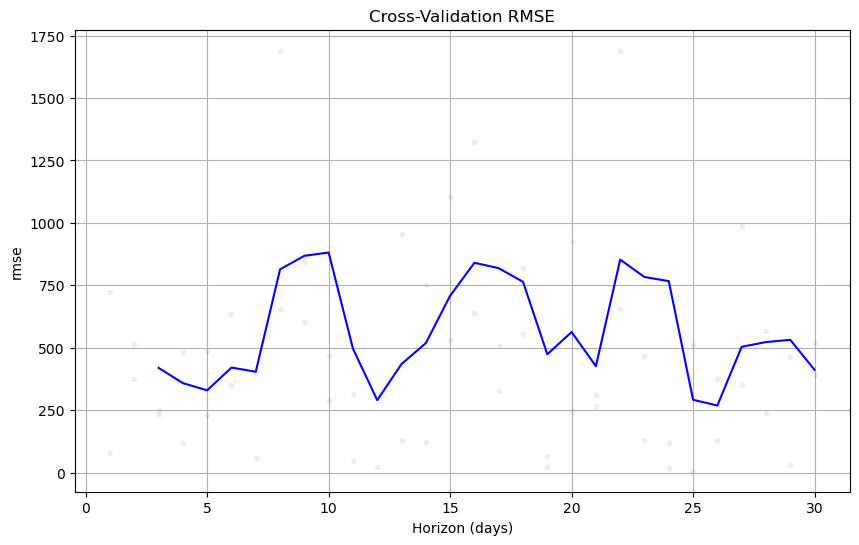

C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


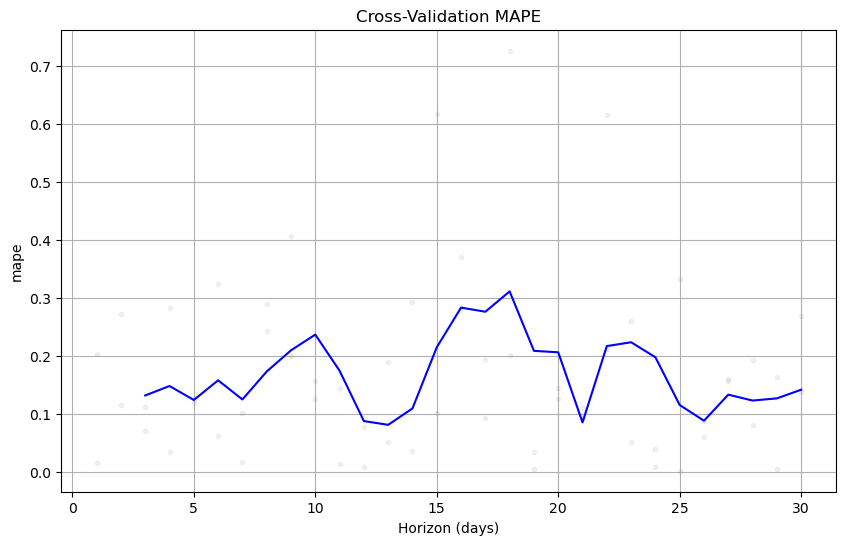

C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\saika\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

R-squared: 0.79


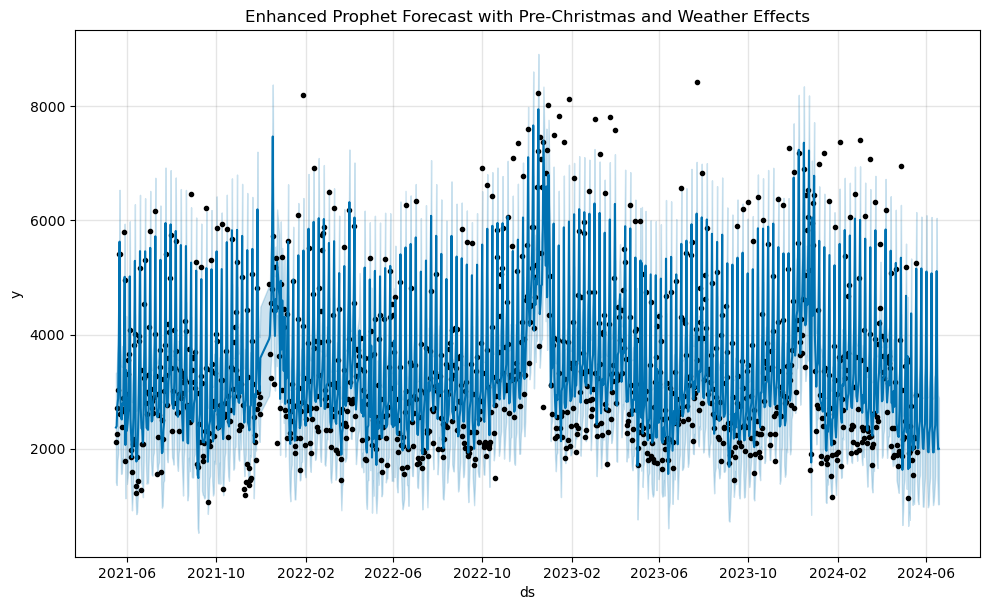

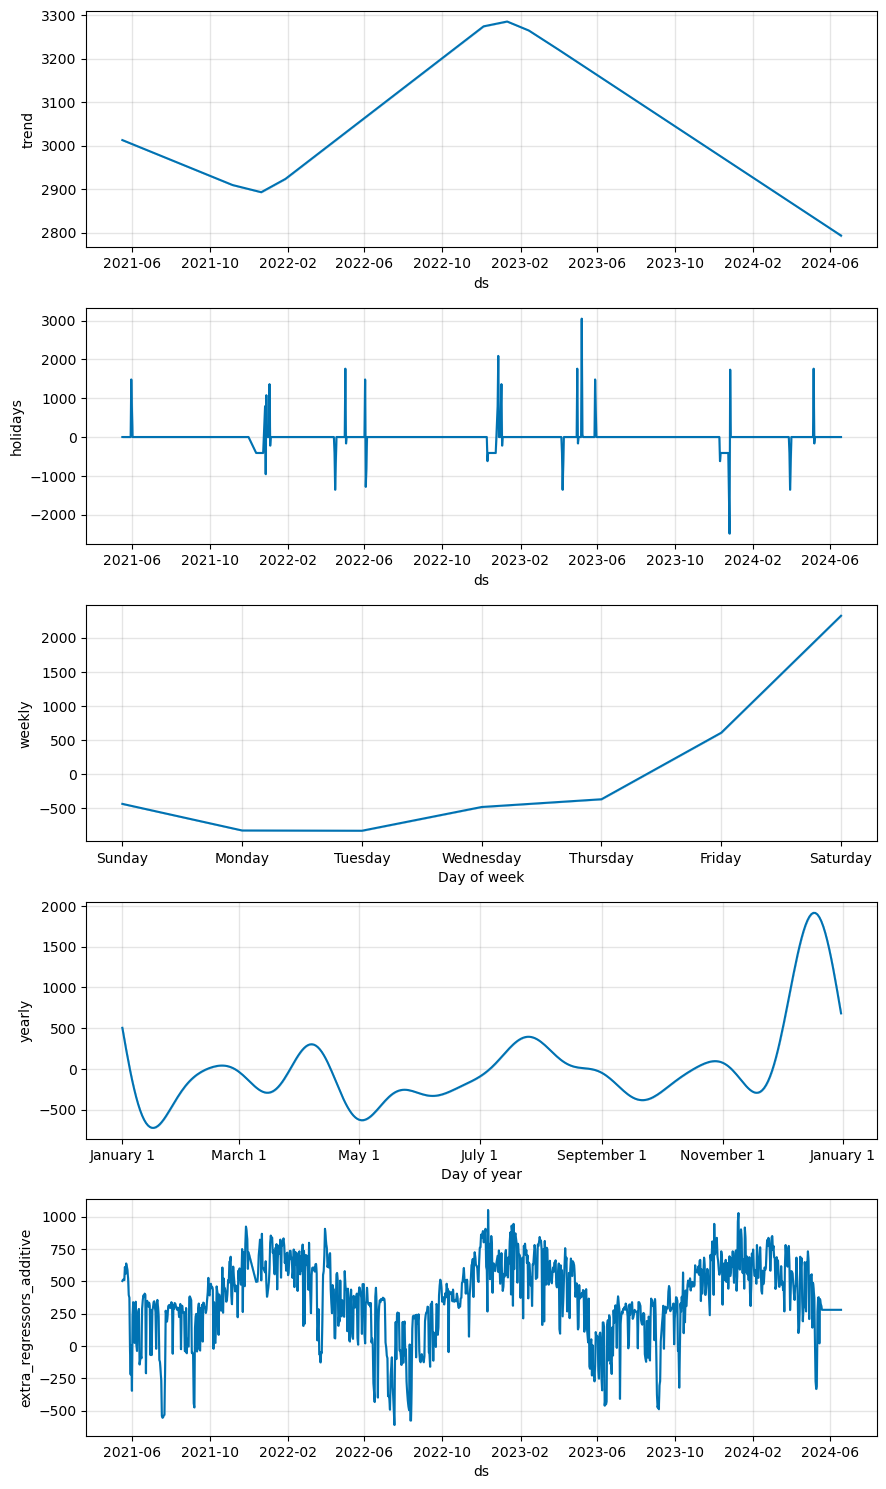

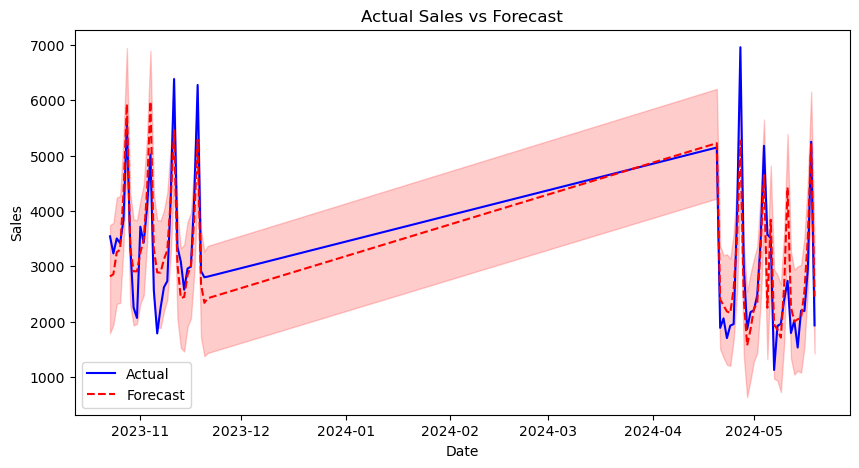

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, message="Parsing dates in .*")
warnings.filterwarnings('ignore', category=FutureWarning, message=".*fillna.*")
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Load your dataset
data = pd.read_csv('Fixed_Combined_Sales_Data.csv')
data['ds'] = pd.to_datetime(data['Date'], dayfirst=True)  # Ensure correct date format
data['y'] = data['TotalNetSales']

# Add weather data and encode weather conditions
data['temperature'] = data['feelslike']
weather_dummies = pd.get_dummies(data['icon'])
data = pd.concat([data, weather_dummies], axis=1)

# Define holidays and special events (Pre-Christmas two weeks)
holidays = data[data['Is_Holiday'] == 1][['ds', 'Holiday_Name']]
holidays['holiday'] = holidays['Holiday_Name']
holidays['lower_window'] = 0
holidays['upper_window'] = 1

# Add Pre-Christmas two weeks before 25th December each year
data['year'] = data['ds'].dt.year
pre_christmas_start = pd.to_datetime(data['year'].astype(str) + '-12-11')
pre_christmas_end = pd.to_datetime(data['year'].astype(str) + '-12-24')

pre_christmas = pd.DataFrame({
    'holiday': 'Pre-Christmas',
    'ds': [pd.date_range(start, end) for start, end in zip(pre_christmas_start, pre_christmas_end)],
    'lower_window': 0,
    'upper_window': 1,
}).explode('ds').drop_duplicates()

# Combine regular and special holidays
holidays = pd.concat([holidays, pre_christmas], ignore_index=True)

model = Prophet(holidays=holidays)
model.add_regressor('temperature')
for condition in weather_dummies.columns:
    model.add_regressor(condition)

# Fit the model on the historical data
model.fit(data[['ds', 'y', 'temperature'] + list(weather_dummies.columns)])

print(weather_dummies.columns)  # Should list all regressors including all weather conditions

# Save the trained model
#joblib.dump(model, 'enhanced_prophet_model.pkl')

# To load the model in your backend or for future use:
# model = joblib.load('enhanced_prophet_model.pkl')

# Create future DataFrame for forecasting
future = model.make_future_dataframe(periods=30, include_history=True)

# Assume future weather conditions or use last known data
future = future.merge(data[['ds', 'temperature'] + list(weather_dummies.columns)], on='ds', how='left', sort=False)

# Handle missing data if any
future.ffill(inplace=True)
future.bfill(inplace=True)

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p[['rmse', 'mae', 'mape']])

# Calculate and print the average RMSE
avg_rmse = df_p['rmse'].mean()
print("Average RMSE:", avg_rmse)

# Calculate and print the average MAE
avg_mae = df_p['mae'].mean()
print("Average MAE:", avg_mae)

# Calculate and print the average MAPE
avg_mape = df_p['mape'].mean()
print("Average MAPE:", avg_mape)

# Plot RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title('Cross-Validation RMSE')
plt.show()

# Plot MAPE
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('Cross-Validation MAPE')
plt.show()

# Predict the future
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Enhanced Prophet Forecast with Pre-Christmas and Weather Effects')

# Plot the forecast components
components_fig = model.plot_components(forecast)

# Calculate SSR (sum of squares of residuals)
ssr = np.sum((df_cv['y'] - df_cv['yhat'])**2)

# Calculate SST (total sum of squares)
sst = np.sum((df_cv['y'] - np.mean(df_cv['y']))**2)

# Calculate R-squared
r_squared = 1 - (ssr / sst)
print(f"R-squared: {r_squared:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(df_cv['ds'], df_cv['y'], 'b-', label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], 'r--', label='Forecast')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='red', alpha=0.2)
plt.title('Actual Sales vs Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
  # Should list all regressors including all weather conditions



In [ ]:
pip list

In [3]:
import warnings
import pandas as pd
from prophet import Prophet
import joblib

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, message="Parsing dates in .*")
warnings.filterwarnings('ignore', category=FutureWarning, message=".*fillna.*")
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Load your dataset
data = pd.read_csv('Fixed_Combined_Sales_Data.csv')
data['ds'] = pd.to_datetime(data['Date'], dayfirst=True)  # Ensure correct date format
data['y'] = data['TotalNetSales']

# Add weather data and encode weather conditions
data['temperature'] = data['feelslike']
weather_dummies = pd.get_dummies(data['icon'])
data = pd.concat([data, weather_dummies], axis=1)

# Define holidays and special events (Pre-Christmas two weeks)
holidays = data[data['Is_Holiday'] == 1][['ds', 'Holiday_Name']]
holidays['holiday'] = holidays['Holiday_Name']
holidays['lower_window'] = 0
holidays['upper_window'] = 1

# Add Pre-Christmas two weeks before 25th December each year
data['year'] = data['ds'].dt.year
pre_christmas_start = pd.to_datetime(data['year'].astype(str) + '-12-11')
pre_christmas_end = pd.to_datetime(data['year'].astype(str) + '-12-24')
pre_christmas = pd.DataFrame({
    'holiday': 'Pre-Christmas',
    'ds': [pd.date_range(start, end) for start, end in zip(pre_christmas_start, pre_christmas_end)],
    'lower_window': 0,
    'upper_window': 1,
}).explode('ds').drop_duplicates()

# Combine regular and special holidays
holidays = pd.concat([holidays, pre_christmas], ignore_index=True)

model = Prophet(holidays=holidays)
model.add_regressor('temperature')
for condition in weather_dummies.columns:
    model.add_regressor(condition)

# Fit the model on the historical data
model.fit(data[['ds', 'y', 'temperature'] + list(weather_dummies.columns)])

# Save the trained model
joblib.dump(model, 'for_fastapi_enhanced_prophet_model.pkl')

# To load the model for future use
# model = joblib.load('enhanced_prophet_model.pkl')


18:00:47 - cmdstanpy - INFO - Chain [1] start processing
18:00:47 - cmdstanpy - INFO - Chain [1] done processing


['for_fastapi_enhanced_prophet_model.pkl']